# Example With Large-Scale Structure (LSS)

This example shows how ``pydftools`` deals with LSS. It mimics example (2) of ``dftools::dfexample``.

In [1]:
# Import relevant libraries
%matplotlib inline

from pydftools import dffit as df
from pydftools.plotting import mfplot, plotcov
from pydftools.model import Schechter
from pydftools.mockdata import mockdata
from pydftools.selection import SelectionRdep

from scipy.special import erf
import numpy as np

import time

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120  # Make figures a little bigger in the notebook

from IPython.display import display, Markdown

In [2]:
# Survey parameters
sigma = 0.3
seed = 1

Let us create a selection function which involves LSS. We define a dew functions, namely, ``f``, which is the selection function which gives the fraction of objects observed at any given combination of $(x,r)$, ``dVdr``, which is the radial derivative of the volume (typically proportional to $r^2$), and ``g``, which is the relative over-/under- abundance of objects at distance $r$ due to cosmic fluctuations:

In [3]:
dmax = lambda x : 1e-3/np.sqrt(10) * np.sqrt(10**x)
f = lambda x, r : erf((dmax(x) - r)/dmax(x)*20)*0.5 + 0.5
dVdr = lambda r : 0.2 * r**2
g = lambda r : 1 + 0.9*np.sin((r/100)**0.6*2*np.pi)

Now create our selection function object:

In [4]:
selection = SelectionRdep(xmin = 5, xmax = 13, rmin = 0, rmax = 100, f=f, dvdr=dVdr, g=g)

Use a Schechter distribution function:

In [5]:
model = Schechter()
p_true = model.p0

In [6]:
data, selection, model, other = mockdata(seed = seed, sigma = sigma, model=model, selection=selection, verbose=True)

Number of sources in the mock survey (expected): 561.057
Number of sources in the mock survey (selected): 561


In [ ]:
data.r = np.genfromtxt('r.txt', skip_header=1)[:,1]

Fit mock daa without any bias correction:

In [7]:
selection_without_lss = SelectionRdep(xmin = 5, xmax = 13, rmin = 0, rmax = 100, f=f, dvdr=dVdr)
survey1 = df.DFFit(data = data, selection = selection_without_lss, ignore_uncertainties=True)

Fit mock data while correcting for observational errors (Eddington bias):

In [8]:
survey2 = df.DFFit(data = data, selection = selection_without_lss)

Fit mock data while correcting observational errors and LSS. We create a new (identical) Selection object, both to keep them conceptually different, and also because the object is mutable, and is changed when estimating the LSS function. If we use the same Selection object, the previous objects will be modified when fitting the following object.

In [9]:
selection_est_lss = SelectionRdep(xmin = 5, xmax = 13, rmin = 0, rmax = 100, f=f, dvdr=dVdr)
survey3 = df.DFFit(data = data, selection = selection_est_lss, correct_lss_bias = True, lss_weight= lambda x : 10**x)

Recall that the fitting is not actually performed until the ``fit`` attribute is accessed. Let's plot the effective volume functions for each of our models *before fitting*:

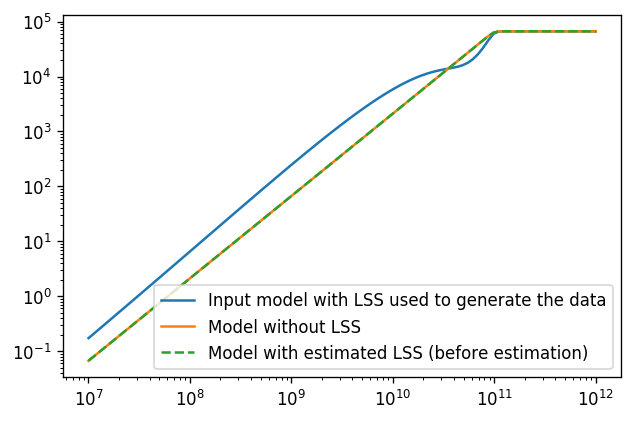

In [10]:
x = np.linspace(7, 12, 100)

plt.plot(10**x, selection.Veff(x), label="Input model with LSS used to generate the data")
plt.plot(10**x, survey1.selection.Veff(x), label="Model without LSS")
plt.plot(10**x, survey3.selection.Veff(x), ls= '--', label="Model with estimated LSS (before estimation)")

plt.xscale('log')
plt.yscale('log')
plt.legend()

Now let's perform the fit and plot the fitted mass functions:

/home/steven/Documents/Projects/DFTOOLS/pydftools/pydftools/plotting.py:405: RuntimeWarning: invalid value encountered in true_divide
  bin['xmean_input'] = np.bincount(x_bins, weights=x) / np.clip(bin['histogram'], 0, np.inf)


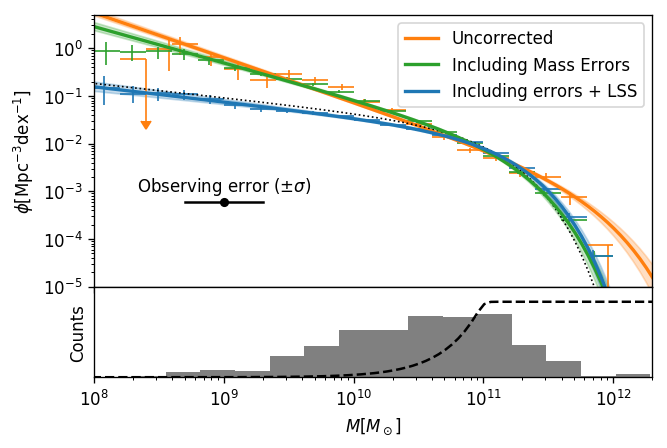

In [16]:
fig, ax = mfplot(survey1, fit_label="Uncorrected", p_true=p_true, xlim=(1e8,2e12),ylim=(1e-5,5),nbins=20,bin_xmin=8,bin_xmax=12,col_fit='C1',col_data='C1',show_data_histogram = True, show_bias_correction = False, show_posterior_data=False)
fig, ax = mfplot(survey2, fit_label="Including Mass Errors", nbins=20, bin_xmin=8,bin_xmax=12,col_fit='C2',col_posterior='C2',show_input_data=False,show_data_histogram = False, fig=fig, ax0=ax[0],ax1=ax[1], show_bias_correction=False)
fig, ax = mfplot(survey3, fit_label="Including errors + LSS", nbins=20, bin_xmin=8,bin_xmax=12,col_fit='C0',col_posterior='C0',show_input_data=False,show_data_histogram = False, fig=fig, ax0=ax[0],ax1=ax[1], show_bias_correction=False)

ax[0].text(1e9, 1e-3, r"Observing error ($\pm \sigma$)",horizontalalignment='center')
ax[0].plot([10**(9 -sigma), 10**(9+sigma)], [0.6e-3, 0.6e-3], color='k')
ax[0].scatter([10**9], [0.6e-3], color='k', s=20)

And again, have a look at the effective volumes (post-fitting):

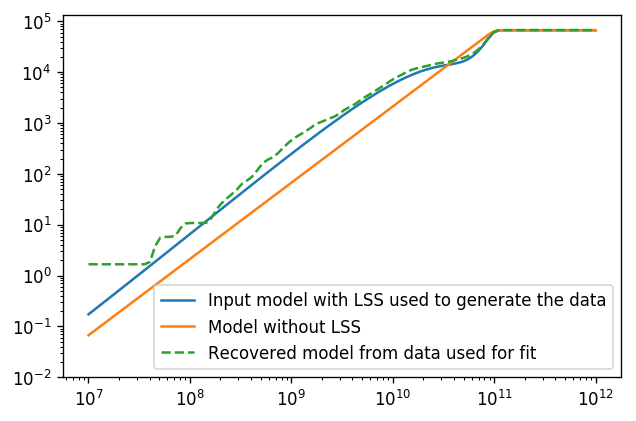

In [12]:
plt.plot(10**x, selection.Veff(x), label="Input model with LSS used to generate the data")
plt.plot(10**x, survey1.selection.Veff(x), label="Model without LSS")
plt.plot(10**x, survey3.selection.Veff(x), ls= '--', label="Recovered model from data used for fit")

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,)
plt.legend()